In [1]:
import sys
sys.path.append('/gpfs/home/ajoshi/bin/')
from libraries_single_cell import *
import libraries_single_cell
protein_coding_genes=libraries_single_cell.get_protein_coding_genes()

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: 

Last run with scvi-tools version: 1.1.4


INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


In [2]:
adata_rna=sc.read_h5ad('/gpfs/home/ajoshi/results/SCORCH_HIV/adata_rna_v2_combined_updated.h5ad')
adata_rna

AnnData object with n_obs × n_vars = 168106 × 30895
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet', 'cell_family'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_family_colors', 'class_colors', 'neighbors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [3]:
atac=sc.read_h5ad('../../results/SCORCH_HIV/atac_updated.h5ad')
atac

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 85234 × 260424
    obs: 'orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'CellType', 'Sample', 'study', 'sample', 'subclass', 'class', 'subtype', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'clusters_poissonvi', 'condition', 'cell_family'
    var: 'genome_pos', 'chr', 'start', 'end', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_family_colors', 'class_colors', 'clusters_poissonvi_colors', 'leiden', 'neighbors', 'subclass_colors', 'umap'
    obsm: 'X_poissonvi', 'X_umap'
    layers: 'fragments', 'logcounts'
    obsp: 'connectivities', 'distances'

In [2]:
micro_adata=sc.read_h5ad('/gpfs/home/ajoshi/HIV_data/single_cell_scorch/microglia_rna_adata.h5ad')
micro_atac=sc.read_h5ad('/gpfs/home/ajoshi/HIV_data/single_cell_scorch/microglia_atac_adata.h5ad')

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
micro_adata

AnnData object with n_obs × n_vars = 6444 × 487
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet', 'cell_family', 'leiden_scVI', 'condition'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_family_colors', 'class_colors', 'leiden', 'leiden_scVI_colors', 'neighbors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [3]:
def get_all_DEG(file_path_diff_exp):
    all_DEG = pd.DataFrame()
    for file in os.listdir(file_path_diff_exp):
        if 'tsv' in file and 'lfc' not in file and 'allcells' not in file:
            diff_exp = pd.read_csv(file_path_diff_exp+file, sep='\t',index_col=0)
            file = file.replace(" ","")
            cell_type = "".join(i for i in file.split('_')[0]).replace('.tsv',"")
            diff_exp.loc[:,'cell_type'] = cell_type
            diff_exp = diff_exp.reset_index().rename(columns={"index":'gene'})
        
            ######For numerical stability: replace infinite values with twice of maximum
            max_twice = diff_exp.loc[diff_exp['log10_pscore'] != np.inf, 'log10_pscore'].max()*2
            diff_exp['log10_pscore'].replace(np.inf,max_twice,inplace=True)
                
            #volcano(diff_exp,cell_type, file_path_diff_exp)
            all_DEG = pd.concat([all_DEG,diff_exp]) #Read in and saved in a previous run is used further in the volcano plot function
    all_DEG = all_DEG.reset_index(drop=True)
    return all_DEG

In [4]:
def get_selection_metric(df):
    selection_metric = df['bayes_factor'] * abs(df['lfc_median'])
    df.loc[:,'selection_metric'] = selection_metric
    return df

In [5]:
all_deg_glia = get_all_DEG('../../results/SCORCH_HIV/diff_exp/glia/hiv_pos_VS_ctrl/')
all_deg_glia = get_selection_metric(all_deg_glia)
all_deg_glia.loc[:,'sign_lfc']=np.where(all_deg_glia['lfc_median']<0,-1,1)
all_deg_glia.loc[:,'metric_gsea'] = all_deg_glia['log10_pscore']*all_deg_glia['sign_lfc']
all_deg_glia = all_deg_glia.sort_values(by='metric_gsea',ascending=False)
all_deg_glia=all_deg_glia.set_index('gene_ids')
all_deg_glia

/tmp/ipykernel_28379/2033498600.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diff_exp['log10_pscore'].replace(np.inf,max_twice,inplace=True)
/tmp/ipykernel_28379/2033498600.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,cell_type,selection_metric,sign_lfc,metric_gsea
gene_ids,,,,,,,,,,,,,,,,,,,,,
CD163,0.9918,0.0082,4.795386,2.749898e-04,3.352584e-06,0.0,0.25,6.195140,6.154420,3.062551,...,0.212035,0.001658,2.780784,0.012859,True,2.086186,Micro,29.512820,1,2.086186
ST14,0.9874,0.0126,4.361378,1.399495e-05,8.057685e-07,0.0,0.25,4.577775,4.516576,2.336659,...,0.021239,0.000829,0.142306,0.008142,True,1.899629,Micro,19.698494,1,1.899629
SLC22A1,0.9848,0.0152,4.171142,7.119654e-06,3.228133e-07,0.0,0.25,4.451330,4.483110,2.482512,...,0.009912,0.000276,0.061601,0.001915,True,1.818156,Micro,18.699689,1,1.818156
SOCS3,0.9846,0.0154,4.157867,1.536452e-05,2.000093e-05,0.0,0.25,4.496700,5.103317,4.440274,...,0.019115,0.018790,0.125085,0.180070,True,1.812479,Micro,21.218916,1,1.812479
ACSL1,0.9838,0.0162,4.106411,4.869384e-04,4.559288e-05,0.0,0.25,3.386738,3.470802,1.574281,...,0.417699,0.046698,4.800740,0.387609,True,1.790485,Micro,14.252540,1,1.790485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NPY,0.9812,0.0188,3.954919,4.133198e-07,6.244514e-06,0.0,0.25,-5.207056,-5.235432,3.325302,...,0.000798,0.009239,0.002986,0.068591,True,1.725842,Astro,20.705708,-1,-1.725842
CRH,0.9812,0.0188,3.954919,3.587705e-07,4.713049e-06,0.0,0.25,-4.446761,-4.539123,2.513135,...,0.000798,0.009440,0.001931,0.049665,True,1.725842,Astro,17.951865,-1,-1.725842
TTC9B,0.9824,0.0176,4.022099,1.948649e-06,2.692129e-05,0.0,0.25,-4.502783,-4.528722,2.582088,...,0.005687,0.041374,0.014179,0.236955,True,1.754487,Astro,18.214970,-1,-1.754487


In [7]:
all_peaks = get_all_DEG('../../results/SCORCH_HIV/differential_accessibility/')
all_peaks = get_selection_metric(all_peaks)
for genome_pos in all_peaks.index:
    all_peaks.loc[genome_pos,'chr']=all_peaks.loc[genome_pos,'gene'].split("-")[0]
    all_peaks.loc[genome_pos,'start']=all_peaks.loc[genome_pos,'gene'].split("-")[1]
    all_peaks.loc[genome_pos,'end']=all_peaks.loc[genome_pos,'gene'].split("-")[2]
all_peaks['start']=all_peaks['start'].astype('int')
all_peaks['end']=all_peaks['end'].astype('int')
all_peaks

/tmp/ipykernel_28016/2033498600.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diff_exp['log10_pscore'].replace(np.inf,max_twice,inplace=True)
/tmp/ipykernel_28016/2033498600.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

,gene,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,...,emp_prob1,emp_prob2,emp_effect,is_de_fdr_0.05,log10_pscore,cell_type,selection_metric,chr,start,end
0,chr5-134926327-134929025,0.9922,0.0078,4.845800,0.000037,0.000104,0.0,0.05,-2.358153,-2.533032,...,0.020656,0.022411,-0.001755,True,2.107905,Oligo,12.274566,chr5,134926327,134929025
1,chr12-113990117-113991271,0.9910,0.0090,4.701489,0.000027,0.000045,0.0,0.05,-1.696554,-1.899759,...,0.009245,0.011477,-0.002232,True,2.045757,Oligo,8.931695,chr12,113990117,113991271
2,chr19-20420617-20421578,0.9906,0.0094,4.657600,0.000088,0.000028,0.0,0.05,1.827464,1.852769,...,0.035566,0.005501,0.030065,True,2.026872,Oligo,8.629459,chr19,20420617,20421578
3,chr1-109687298-109688274,0.9902,0.0098,4.615524,0.000129,0.000028,0.0,0.05,2.898598,2.957738,...,0.051058,0.000951,0.050107,True,2.008774,Oligo,13.651509,chr1,109687298,109688274
4,chr2-3604893-3605778,0.9898,0.0102,4.575114,0.000022,0.000084,0.0,0.05,-2.412437,-2.498427,...,0.004081,0.022886,-0.018805,True,1.991400,Oligo,11.430591,chr2,3604893,3605778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61617,chr17-76264653-76265644,0.8794,0.1206,1.986761,0.000312,0.000301,0.0,0.05,0.031172,0.069091,...,0.090226,0.129114,-0.038888,False,0.918653,Vascular,0.137268,chr17,76264653,76265644
61618,chr9-71910818-71911809,0.8734,0.1266,1.931361,0.000341,0.000336,0.0,0.05,-0.014781,0.051555,...,0.108605,0.124051,-0.015446,False,0.897566,Vascular,0.099571,chr9,71910818,71911809
61619,chr8-109539281-109540247,0.8702,0.1298,1.902728,0.000435,0.000422,0.0,0.05,-0.001876,0.060387,...,0.136174,0.135443,0.000731,False,0.886725,Vascular,0.114899,chr8,109539281,109540247
61620,chr6-73520808-73521770,0.8318,0.1682,1.598438,0.000474,0.000471,0.0,0.05,-0.013203,0.045037,...,0.137009,0.130380,0.006629,False,0.774174,Vascular,0.071989,chr6,73520808,73521770


In [8]:
micro_adata=adata_rna[np.where(adata_rna.obs.subclass=='Micro')[0],
np.where(adata_rna.var.index.isin(list(
    all_deg_glia.iloc[np.where((all_deg_glia['is_de_fdr_0.05']==True)&(all_deg_glia.cell_type=='Micro')
                               &(all_deg_glia['proba_not_de']<=0.05))[0],:].index
)))[0]].copy()
micro_adata

AnnData object with n_obs × n_vars = 6444 × 487
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet', 'cell_family'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_family_colors', 'class_colors', 'neighbors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [9]:
micro_adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,sample,percent.mt,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,study,...,TopSubclassScore,TopClassScore,TopSubtypeScore,integrated_snn_res.0.5,ident,n_genes,_scvi_batch,_scvi_labels,doublet,cell_family
6801066772_HIV_PFC_MAH_AAAGCAAGTATTCGTC-1,SeuratProject,1638.0,1130,6801066772_HIV_PFC_MAH,0.366300,4796.0,1696,15,5,Spudich,...,0.787002,0.787002,0.657158,5,5,1130,0,0,singlet,Immune
6801066772_HIV_PFC_MAH_AACATCATCCTGGCTT-1,SeuratProject,3044.0,1624,6801066772_HIV_PFC_MAH,0.065703,5423.0,1695,15,5,Spudich,...,0.803161,0.803161,0.631300,5,5,1624,0,0,singlet,Immune
6801066772_HIV_PFC_MAH_AAGTTAGCACTAAGCC-1,SeuratProject,2031.0,1257,6801066772_HIV_PFC_MAH,0.000000,4987.0,1640,15,5,Spudich,...,0.658055,0.658055,0.582524,5,5,1257,0,0,singlet,Immune
6801066772_HIV_PFC_MAH_ACCAGGGAGGCATTAC-1,SeuratProject,3504.0,1779,6801066772_HIV_PFC_MAH,0.028539,5393.0,1794,15,5,Spudich,...,0.826852,0.826852,0.664233,5,5,1779,0,0,singlet,Immune
6801066772_HIV_PFC_MAH_AGCCTAGTCCAGGGAG-1,SeuratProject,2869.0,1606,6801066772_HIV_PFC_MAH,0.174277,5410.0,1707,15,5,Spudich,...,0.864639,0.864639,0.689264,5,5,1606,0,0,singlet,Immune
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HCTXJ_CTR_PFC_TTTCTCACAACCTGGT-1,SeuratProject,1091.0,793,HCTXJ_CTR_PFC,0.000000,3564.0,1433,11,5,Spudich,...,0.799794,0.799794,0.780410,5,5,793,0,0,singlet,Immune
HCTXJ_CTR_PFC_TTTCTCACACTGACTA-1,SeuratProject,1035.0,772,HCTXJ_CTR_PFC,0.193237,3530.0,1439,11,5,Spudich,...,0.759148,0.759148,0.729078,5,5,772,0,0,singlet,Immune
HCTXJ_CTR_PFC_TTTGACTTCACTCGCT-1,SeuratProject,1474.0,1090,HCTXJ_CTR_PFC,0.135685,3787.0,1572,11,5,Spudich,...,0.813195,0.813195,0.762550,5,5,1090,0,0,singlet,Immune
HCTXJ_CTR_PFC_TTTGACTTCGCTAAGT-1,SeuratProject,1029.0,762,HCTXJ_CTR_PFC,0.097182,3539.0,1417,11,5,Spudich,...,0.835336,0.835336,0.789270,5,5,762,0,0,singlet,Immune


In [5]:
gene_sets_to_test = ['GO_Biological_Process_2023','GO_Cellular_Component_2023','GO_Molecular_Function_2023',
                    'WikiPathway_2023_Human',
                    'MSigDB_Hallmark_2020',
                    'KEGG_2021_Human']

/gpfs/home/ajoshi/.scvi_venv/lib/python3.11/site-packages/scvi/model/_scvi.py:161: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(
/gpfs/home/ajoshi/.scvi_venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.scvi_venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `sru

Epoch 400/400: 100%|█████████████████████████████████████████████████████████████████████| 400/400 [03:09<00:00,  2.17it/s, v_num=1, train_loss_step=24.2, train_loss_epoch=28.1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████████████████████████████████████████████████████████████| 400/400 [03:09<00:00,  2.11it/s, v_num=1, train_loss_step=24.2, train_loss_epoch=28.1]


/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


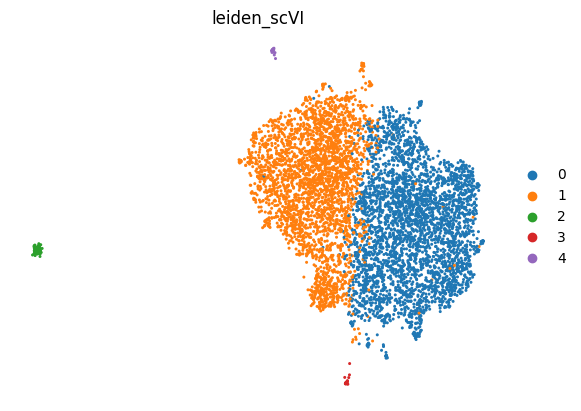

In [10]:
scvi.model.SCVI.setup_anndata(micro_adata, layer='logcounts',
                              #categorical_covariate_keys=['study'],
                              #continuous_covariate_keys=["Age at Death"]
                             )
model = scvi.model.SCVI(micro_adata)
model.train()
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
micro_adata.obsm[SCVI_LATENT_KEY] = latent
sc.pp.neighbors(micro_adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(micro_adata, min_dist=0.3)

sc.pp.neighbors(micro_adata,use_rep='X_scVI')
sc.tl.leiden(micro_adata, key_added="leiden_scVI", resolution=0.21)
sc.pl.umap(
    micro_adata,
    color=["leiden_scVI"],
    frameon=False,
)

In [11]:
print(torch.cuda.is_available())
print(torch.__version__)

True
2.6.0+cu124


In [12]:
micro_adata.obs.leiden_scVI.value_counts()

leiden_scVI
0    3399
1    2876
2     121
3      27
4      21
Name: count, dtype: int64

In [13]:
micro_adata.obs['condition']=np.where(((micro_adata.obs['sample'].str.contains('HIV'))),'hiv','ctrl')

In [10]:
de_change0=pd.read_csv('/gpfs/home/ajoshi/results/SCORCH_HIV/de_change_microglia_cluster0.tsv',sep='\t',index_col=0)
de_change1=pd.read_csv('/gpfs/home/ajoshi/results/SCORCH_HIV/de_change_microglia_cluster1.tsv',sep='\t',index_col=0)

In [28]:
glycolysis_custom_gene_set=[
'ALDOA', 'BPGM','ENO1','ENO2' ,'GAPDH','GPI','HK1', 'HK2', 'HKDC1', 'PFKL','PFKM','PGAM1','PGAM2','PGAM4','PGK1','PKLR','PKM','TPI1'
]

In [29]:
de_change0.loc[glycolysis_custom_gene_set,:]

KeyError: "None of [Index(['ALDOA', 'BPGM', 'ENO1', 'ENO2', 'GAPDH', 'GPI', 'HK1', 'HK2', 'HKDC1',\n       'PFKL', 'PFKM', 'PGAM1', 'PGAM2', 'PGAM4', 'PGK1', 'PKLR', 'PKM',\n       'TPI1'],\n      dtype='object', name='gene_ids')] are in the [index]"

In [30]:
de_change1=de_change1.sort_values(by='metric_gsea',ascending=False)
diff_exp=de_change1
gene_set=glycolysis_custom_gene_set
gsea_result = gseapy.prerank(rnk=diff_exp[~diff_exp.index.duplicated(keep='first')].metric_gsea,
                                 gene_sets={"Differential expression signature in Microglia: No. of elements:"+str(len(diff_exp[~diff_exp.index.duplicated(keep='first')]))+"(in full list), "+ str(len(gene_set))+" in element set" 
                                            :gene_set}, max_size=500, min_size=5, figsize=10
                            ,organism='human')

gseapy.gseaplot(rank_metric=gsea_result.ranking, term=gsea_result.res2d.Term[0], **gsea_result.results[gsea_result.res2d.Term[0]],color='blue')

2025-08-25 13:34:16,964 [WARNING] Duplicated values found in preranked stats: 40.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-08-25 13:34:16,965 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

2025-08-25 13:34:16,966 [ERROR] The first entry of your gene_sets (gmt) look like this : { Differential expression signature in Microglia: No. of elements:487(in full list), 18 in element set: [ALDOA, BPGM, ENO1, ENO2, GAPDH, GPI, HK1, HK2, HKDC1, PFKL, PFKM, PGAM1, PGAM2, PGAM4, PGK1, PKLR, PKM, TPI1]}
2025-08-25 13:34:16,967 [ERROR] The first 5 genes look like this : [ CD163, CLEC5A, SOCS3, DTL, ENSG00000284762 ]


LookupError: No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.


/gpfs/home/ajoshi/.scvi_venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.scvi_venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████| 500/500 [11:53<00:00,  1.44s/it, v_num=1, train_loss_step=30.9, train_loss_epoch=29.8]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████| 500/500 [11:53<00:00,  1.43s/it, v_num=1, train_loss_step=30.9, train_loss_epoch=29.8]


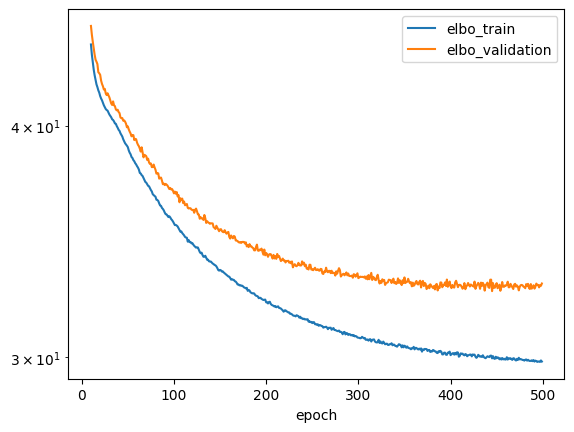

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.36s/it]


In [13]:
cells = list(np.where(micro_adata.obs.leiden_scVI=='0')[0])
micro_adata0 = micro_adata[cells].copy()
scvi.model.SCVI.setup_anndata(micro_adata0, #layer="UMIs",
                                  categorical_covariate_keys=['sample']
                                  #continuous_covariate_keys=["Age at Death"]
                                 )
model = scvi.model.SCVI(
    micro_adata0, gene_likelihood="nb")  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
model.train(check_val_every_n_epoch=1,
        max_epochs=500,
        early_stopping=True,
        early_stopping_patience=200,
        early_stopping_monitor="elbo_validation",
        batch_size=55,
        plan_kwargs={"lr": 0.0001})
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
plt.show()
de_change0 = model.differential_expression(idx1=micro_adata0.obs['condition']=='hiv',
                                       idx2=micro_adata0.obs['condition']=='ctrl', weights="uniform", filter_outlier_cells=True)
    
#de_change = de_change.loc[de['is_de_fdr_0.05']==True,:]
de_change0.loc[:,"log10_pscore"] = (-1)*np.log10(de_change0["proba_not_de"])

In [31]:
de_change0.iloc[np.where((de_change0['is_de_fdr_0.05']==True)&(de_change0['proba_not_de']<=0.05))[0],:]#.iloc[0:20]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,sign_lfc,metric_gsea
gene_ids,,,,,,,,,,,,,,,,,,,,,
ADGRE2,0.9628,0.0372,3.253537,0.009080,0.002282,0.0,0.25,2.985627,3.147841,2.434178,...,0.198603,0.013398,0.154383,0.010962,95.741710,22.307596,True,1.429457,1,1.429457
CD163,0.9580,0.0420,3.127178,0.016795,0.001571,0.0,0.25,2.851180,2.868606,2.581412,...,0.528705,0.003654,0.225369,0.003654,168.175000,7.498069,True,1.376751,1,1.376751
TGFBI,0.9560,0.0440,3.078568,0.000631,0.000147,0.0,0.25,1.381793,1.720123,2.929108,...,0.019395,0.000000,0.017843,0.000000,6.831065,0.000000,True,1.356547,1,1.356547
MYO1G,0.9544,0.0456,3.041175,0.000610,0.000133,0.0,0.25,2.399302,2.393933,2.885863,...,0.017843,0.000000,0.017455,0.000000,5.967826,0.000000,True,1.341035,1,1.341035
HAMP,0.9540,0.0460,3.032022,0.007294,0.001648,0.0,0.25,2.449173,2.566114,2.437829,...,0.169511,0.017052,0.121412,0.012180,69.460130,17.313751,True,1.337242,1,1.337242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SOX15,0.9792,0.0208,3.851782,0.000047,0.000871,0.0,0.25,-4.453601,-4.413437,3.154605,...,0.000388,0.006090,0.000388,0.006090,0.277070,15.732847,True,1.681937,-1,-1.681937
HHATL,0.9828,0.0172,4.045496,0.000023,0.000544,0.0,0.25,-4.634048,-4.519385,2.682520,...,0.000000,0.003654,0.000000,0.003654,0.000000,6.815150,True,1.764472,-1,-1.764472
CTF1,0.9846,0.0154,4.157867,0.000014,0.000418,0.0,0.25,-4.623204,-4.675046,2.743047,...,0.000388,0.002436,0.000388,0.002436,0.129299,3.789417,True,1.812479,-1,-1.812479


In [33]:
set(de_change1.iloc[np.where((de_change1['is_de_fdr_0.05']==True)&(de_change1['proba_not_de']<=0.05))[0],:].index).intersection(
    glycolysis_custom_gene_set
)

set()

In [35]:
set(all_deg_glia.iloc[np.where((all_deg_glia.cell_type.str.contains('Micro')))[0],:].index).intersection(
    glycolysis_custom_gene_set
)

{'ALDOA',
 'BPGM',
 'ENO1',
 'ENO2',
 'GAPDH',
 'GPI',
 'HK1',
 'HK2',
 'PFKL',
 'PFKM',
 'PGAM1',
 'PGK1',
 'PKM',
 'TPI1'}

In [8]:
gene_sets_to_test = ['GO_Biological_Process_2023','GO_Cellular_Component_2023','GO_Molecular_Function_2023',
                    'WikiPathway_2023_Human',
                    'MSigDB_Hallmark_2020',
                    'KEGG_2021_Human']
de_change0.loc[:,'sign_lfc']=np.where(de_change0['lfc_median']<0,-1,1)
col = np.where(de_change0.columns=='log10_pscore')[0]
de_change0.loc[:,'metric_gsea'] = de_change0['log10_pscore']*de_change0['sign_lfc']
input_gsea = pd.DataFrame(columns=['metric_gsea'])
input_gsea = de_change0.loc[:,'metric_gsea']
input_gsea = input_gsea.sort_values(ascending=False)
gsea_all_paths0 = pd.DataFrame()
        
## Exception handling for when the gmt gene set is irrelevant for the differentially expressed genes
gsea_result = gseapy.prerank(rnk=input_gsea, gene_sets=gene_sets_to_test, organism='human')
    
filtered_sets = gsea_result.res2d
if len(filtered_sets)>0:
    gsea_all_paths0 = pd.concat([gsea_all_paths0,filtered_sets]).reset_index(drop=True)
    gsea_all_paths0=gsea_all_paths0.drop_duplicates()

list(gsea_all_paths0.iloc[np.where(gsea_all_paths0['NOM p-val']<=0.05)[0],:].Term)

2025-06-28 22:37:59,397 [WARNING] Duplicated values found in preranked stats: 36.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


['GO_Biological_Process_2023__Positive Regulation Of Cytokine Production (GO:0001819)',
 'WikiPathway_2023_Human__Pleural Mesothelioma WP5087',
 'GO_Molecular_Function_2023__RNA Polymerase II Transcription Regulatory Region Sequence-Specific DNA Binding (GO:0000977)',
 'GO_Molecular_Function_2023__Cis-Regulatory Region Sequence-Specific DNA Binding (GO:0000987)',
 'GO_Cellular_Component_2023__Intracellular Non-Membrane-Bounded Organelle (GO:0043232)',
 'GO_Cellular_Component_2023__Cytoskeleton (GO:0005856)',
 'GO_Molecular_Function_2023__Double-Stranded DNA Binding (GO:0003690)',
 'GO_Biological_Process_2023__Regulation Of Inflammatory Response (GO:0050727)',
 'GO_Biological_Process_2023__Inflammatory Response (GO:0006954)']

/gpfs/home/ajoshi/.scvi_venv/lib/python3.11/site-packages/scvi/data/fields/_arraylike_field.py:410: UserWarning: Category 7 in adata.obs['sample'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(df, key, key, categorical_dtype=categorical_dtype)
/gpfs/home/ajoshi/.scvi_venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.scvi_venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python 

Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████| 500/500 [10:24<00:00,  1.24s/it, v_num=1, train_loss_step=20.4, train_loss_epoch=22.6]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█████████████████████████████████████████████████████████████████████| 500/500 [10:24<00:00,  1.25s/it, v_num=1, train_loss_step=20.4, train_loss_epoch=22.6]


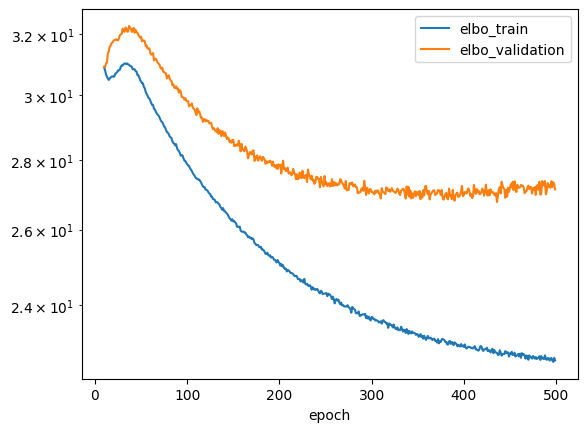

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


In [16]:
cells = list(np.where(micro_adata.obs.leiden_scVI=='1')[0])
micro_adata1 = micro_adata[cells].copy()
scvi.model.SCVI.setup_anndata(micro_adata1, #layer="UMIs",
                                  categorical_covariate_keys=['sample']
                                  #continuous_covariate_keys=["Age at Death"]
                                 )
model = scvi.model.SCVI(
    micro_adata1, gene_likelihood="nb")  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
model.train(
    check_val_every_n_epoch=1,
        max_epochs=500,
        early_stopping=True,
        early_stopping_patience=200,
        early_stopping_monitor="elbo_validation",
        batch_size=53,
        plan_kwargs={"lr": 0.0001}
)
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
plt.show()
de_change1 = model.differential_expression(idx1=micro_adata1.obs['condition']=='hiv',
                                       idx2=micro_adata1.obs['condition']=='ctrl', weights="uniform", filter_outlier_cells=True)
    
#de_change = de_change.loc[de['is_de_fdr_0.05']==True,:]
de_change1.loc[:,"log10_pscore"] = (-1)*np.log10(de_change1["proba_not_de"])

In [22]:
de_change1.iloc[np.where((de_change1['is_de_fdr_0.05']==True)&(de_change1['proba_not_de']<=0.05))[0],:]#.iloc[0:20]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,sign_lfc,metric_gsea
gene_ids,,,,,,,,,,,,,,,,,,,,,
ACY3,0.9768,0.0232,3.740129,0.000402,0.007290,0.0,0.25,-4.032439,-4.132113,2.775145,...,0.000000,0.033763,0.000000,0.033384,0.000000,77.302246,True,1.634512,-1,-1.634512
MORN2,0.9756,0.0244,3.688469,0.000077,0.001568,0.0,0.25,-4.181169,-4.141330,2.783280,...,0.004167,0.009863,0.004167,0.009863,2.976191,20.727470,True,1.612610,-1,-1.612610
GPA33,0.9742,0.0258,3.631242,0.000035,0.000771,0.0,0.25,-3.797008,-3.864619,3.126491,...,0.000000,0.003794,0.000000,0.003794,0.000000,6.703717,True,1.588380,-1,-1.588380
GOLGA6L7,0.9708,0.0292,3.503951,0.000116,0.001096,0.0,0.25,-3.304593,-3.568580,3.223629,...,0.004167,0.005311,0.004167,0.005311,2.976191,10.850676,True,1.534617,-1,-1.534617
GAL3ST3,0.9696,0.0304,3.462441,0.000024,0.000451,0.0,0.25,-3.625889,-3.505746,3.912028,...,0.000000,0.004552,0.000000,0.004552,0.000000,3.994895,True,1.517126,-1,-1.517126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DUSP2,0.9504,0.0496,2.952892,0.000866,0.000663,0.0,0.25,-0.201777,-0.327729,4.117290,...,0.008333,0.003794,0.008333,0.003794,6.365741,5.503654,True,1.304518,-1,-1.304518
GRM4,0.9504,0.0496,2.952892,0.001523,0.000209,0.0,0.25,2.092154,2.065596,3.275184,...,0.025000,0.000759,0.020833,0.000759,8.581763,0.528919,True,1.304518,1,1.304518
NPB,0.9504,0.0496,2.952892,0.000040,0.000433,0.0,0.25,-2.734441,-2.568985,2.813162,...,0.000000,0.003794,0.000000,0.003794,0.000000,4.300165,True,1.304518,-1,-1.304518


In [9]:
gene_sets_to_test = ['GO_Biological_Process_2023','GO_Cellular_Component_2023','GO_Molecular_Function_2023',
                    'WikiPathway_2023_Human',
                    'MSigDB_Hallmark_2020',
                    'KEGG_2021_Human']
de_change1.loc[:,'sign_lfc']=np.where(de_change1['lfc_median']<0,-1,1)
col = np.where(de_change1.columns=='log10_pscore')[0]
de_change1.loc[:,'metric_gsea'] = de_change1['log10_pscore']*de_change1['sign_lfc']
input_gsea = pd.DataFrame(columns=['metric_gsea'])
input_gsea = de_change1.loc[:,'metric_gsea']
input_gsea = input_gsea.sort_values(ascending=False)
gsea_all_paths1 = pd.DataFrame()
        
## Exception handling for when the gmt gene set is irrelevant for the differentially expressed genes
gsea_result = gseapy.prerank(rnk=input_gsea, gene_sets=gene_sets_to_test, organism='human')
    
filtered_sets = gsea_result.res2d
if len(filtered_sets)>0:
    gsea_all_paths1 = pd.concat([gsea_all_paths1,filtered_sets]).reset_index(drop=True)
    gsea_all_paths1=gsea_all_paths1.drop_duplicates()

list(gsea_all_paths1.iloc[np.where(gsea_all_paths1['NOM p-val']<=0.05)[0],:].Term)

2025-06-28 22:38:12,254 [WARNING] Duplicated values found in preranked stats: 40.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


['GO_Biological_Process_2023__Regulation Of Apoptotic Process (GO:0042981)',
 'GO_Biological_Process_2023__Positive Regulation Of Intracellular Signal Transduction (GO:1902533)',
 'GO_Cellular_Component_2023__Cytoskeleton (GO:0005856)',
 'GO_Biological_Process_2023__Negative Regulation Of Programmed Cell Death (GO:0043069)',
 'GO_Biological_Process_2023__Negative Regulation Of Apoptotic Process (GO:0043066)',
 'GO_Biological_Process_2023__Regulation Of DNA-templated Transcription (GO:0006355)',
 'GO_Biological_Process_2023__Regulation Of Inflammatory Response (GO:0050727)',
 'GO_Molecular_Function_2023__Sequence-Specific Double-Stranded DNA Binding (GO:1990837)']

In [7]:
def get_lead_genes(paths):
    all_lead_genes = []
    all_ld_gns = paths[paths['NOM p-val']<0.05].Lead_genes.reset_index(drop=True)
    for i in all_ld_gns.index:
        gene_list = all_ld_gns[i].split(';')
        for j in gene_list:
            all_lead_genes.append(j)
    return all_lead_genes#list(set(all_lead_genes).intersection(protein_coding_genes))

In [27]:
str(sorted(set(get_lead_genes(gsea_all_paths0.iloc[np.where((gsea_all_paths0['NOM p-val']<=0.05)&
                                                 ((gsea_all_paths0.Term.str.contains('Cytokine')|
                                                   (gsea_all_paths0.Term.str.contains('Inflammatory'))))
                                                )[0],:])).intersection(de_change0.iloc[np.where(de_change0['is_de_fdr_0.05']==True)[0],:].index)
          ))

"['ALOX15B', 'BCL6', 'FGR', 'FPR3', 'IL15', 'OSM', 'SIGLEC1', 'SLC11A1', 'TAC1']"

In [28]:
str(sorted(set(get_lead_genes(gsea_all_paths1.iloc[np.where((gsea_all_paths1['NOM p-val']<=0.05)&
                                                 ((gsea_all_paths1.Term.str.contains('Apoptotic')|
                                                   (gsea_all_paths1.Term.str.contains('Cell Death'))))
                                            )[0],:])).intersection(de_change1.iloc[np.where(de_change1['is_de_fdr_0.05']==True)[0],:].index)
          ))

"['BCL2A1', 'BCL3', 'BCL6', 'CIDEB', 'CLEC5A', 'GADD45B', 'GRM4', 'LEF1', 'NUPR1', 'PAWR', 'PIM1', 'SH3RF2', 'SOCS3', 'TEK', 'TGM2', 'TOX3']"

In [19]:
de_change0.to_csv('/gpfs/home/ajoshi/results/SCORCH_HIV/de_change_microglia_cluster0.tsv',sep='\t')
de_change1.to_csv('/gpfs/home/ajoshi/results/SCORCH_HIV/de_change_microglia_cluster1.tsv',sep='\t')

In [82]:
heatmap_genes_rna=list(set(de_change0.iloc[np.where((de_change0['is_de_fdr_0.05']==True)&
                        (de_change0.index.isin(get_lead_genes(gsea_all_paths0.iloc[np.where(gsea_all_paths0['NOM p-val']<=0.05)[0],:])))
                        )[0],:].index).union(set(de_change1.iloc[np.where((de_change1['is_de_fdr_0.05']==True)&
                        (de_change1.index.isin(get_lead_genes(gsea_all_paths1.iloc[np.where(gsea_all_paths1['NOM p-val']<=0.05)[0],:])))
                        )[0],:].index)))

In [201]:
de_change0

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,sign_lfc,metric_gsea
gene_ids,,,,,,,,,,,,,,,,,,,,,
DPP4,0.9900,0.0100,4.595119,0.000111,0.004677,0.0,0.25,-6.102586,-6.235810,3.427299,...,0.002327,0.023143,0.002327,0.021924,1.209551,42.636170,True,2.000000,-1,-2.000000
PRDM11,0.9854,0.0146,4.212025,0.003400,0.033583,0.0,0.25,-3.629684,-3.599199,2.049890,...,0.062451,0.161998,0.054694,0.130329,34.887196,259.129270,True,1.835647,-1,-1.835647
CTF1,0.9846,0.0154,4.157867,0.000014,0.000418,0.0,0.25,-4.623204,-4.675046,2.743047,...,0.000388,0.002436,0.000388,0.002436,0.129299,3.789417,True,1.812479,-1,-1.812479
HHATL,0.9828,0.0172,4.045496,0.000023,0.000544,0.0,0.25,-4.634048,-4.519385,2.682520,...,0.000000,0.003654,0.000000,0.003654,0.000000,6.815150,True,1.764472,-1,-1.764472
SOX15,0.9792,0.0208,3.851782,0.000047,0.000871,0.0,0.25,-4.453601,-4.413437,3.154605,...,0.000388,0.006090,0.000388,0.006090,0.277070,15.732847,True,1.681937,-1,-1.681937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NLRC5,0.8692,0.1308,1.893904,0.009715,0.008186,0.0,0.25,0.478528,0.483649,1.322026,...,0.195500,0.043849,0.167572,0.040195,100.987030,81.206400,False,0.883392,1,0.883392
TBC1D14,0.8550,0.1450,1.774368,0.041357,0.037614,0.0,0.25,0.166719,0.152049,1.348864,...,0.826229,0.208282,0.491466,0.172960,412.476470,378.955080,False,0.838632,1,0.838632
FKBP5,0.8504,0.1496,1.737742,0.167479,0.134265,0.0,0.25,0.553694,0.508000,1.298464,...,3.899581,0.757611,0.850272,0.394641,1687.477200,1265.759500,False,0.825068,1,0.825068


In [204]:
frame=pd.DataFrame()
annot=pd.DataFrame()

for gene in heatmap_genes_rna:
    frame.loc[gene,'Cluster 0'] = de_change0.loc[gene,'metric_gsea']
    
    if de_change0.loc[gene,'is_de_fdr_0.05']==True:
        annot.loc[gene,'Cluster 0']='*'
    else:
        annot.loc[gene,'Cluster 0']=''
        
    frame.loc[gene,'Cluster 1'] = de_change1.loc[gene,'metric_gsea']
    
    if de_change1.loc[gene,'is_de_fdr_0.05']==True:
        annot.loc[gene,'Cluster 1']='*'
    else:
        annot.loc[gene,'Cluster 1']=''

frame

,Cluster 0,Cluster 1
CTHRC1,-1.287350,-1.406714
SH3RF2,-1.184422,1.366532
CREB3L1,-1.071604,-1.306273
MYO1G,1.341035,1.149967
HEY1,-1.429457,-1.239578
...,...,...
FGF5,-1.230623,-1.248721
TGM2,-1.262807,1.250264
BCL3,1.137869,1.224754
DBP,-1.304518,-1.329754


In [205]:
annot

,Cluster 0,Cluster 1
CTHRC1,*,*
SH3RF2,*,*
CREB3L1,,*
MYO1G,*,
HEY1,*,*
...,...,...
FGF5,*,*
TGM2,*,*
BCL3,,*
DBP,*,*


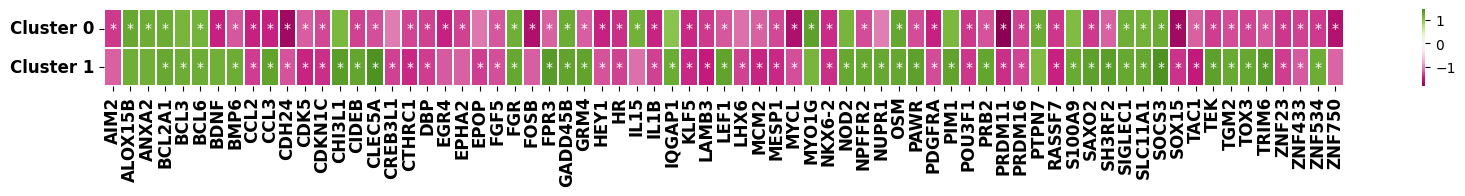

In [209]:
plt.subplots(figsize=(20,1))
plt.yticks(size = 12, weight = 'bold')
plt.xticks(size = 12, weight = 'bold')
sns.heatmap(np.transpose(frame.loc[sorted(frame.index),:]),cmap = 'PiYG',center=0,yticklabels=True,linewidths=0.01,
            annot=np.transpose(annot.loc[sorted(annot.index),:]),fmt='')#annot_kws={"size":"10","weight":"bold",'color':'black'})
plt.savefig('../../results/SCORCH_HIV/figures/microglia_rna_clusters_degs.tiff',dpi=400,bbox_inches='tight')

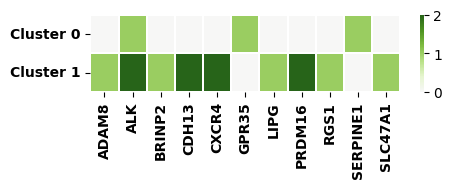

In [195]:
plt.subplots(figsize=(5,1))
plt.yticks(size = 10, weight = 'bold')
plt.xticks(size = 10, weight = 'bold')
frame_atac=num_peaks_for_genes.iloc[np.where((num_peaks_for_genes.sum(axis=1)>=1))[0],:]
frame_atac=frame_atac.rename({'0':'Cluster 0','1':'Cluster 1'},axis=1).astype('float')
sns.heatmap(np.transpose(frame_atac.loc[sorted(frame_atac.index),:]),cmap = 'PiYG',center=0,yticklabels=True,linewidths=0.01)
plt.savefig('../../results/SCORCH_HIV/figures/microglia_atac_clusters_degs_dars.tiff',dpi=400,bbox_inches='tight')

In [159]:
frame_atac

,Cluster 0,Cluster 1
FGR,7.0,38.0
TBC1D8,3.0,14.0
SLAMF8,7.0,38.0
SLC11A1,3.0,14.0
S1PR1,7.0,38.0
...,...,...
TNFSF18,7.0,38.0
TTC30A,3.0,14.0
EGR4,3.0,14.0
OR2L5,7.0,38.0


In [16]:
micro_atac=atac[np.where(atac.obs.subclass=='Micro')[0],
np.where(atac.var.index.isin(list(
    all_peaks.iloc[np.where((all_peaks['is_de_fdr_0.05']==True)&(all_peaks.cell_type=='Immune')
                               &(all_peaks['proba_not_de']<=0.05))[0],:].gene
)))[0]].copy()
micro_atac

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 3486 × 1695
    obs: 'orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'CellType', 'Sample', 'study', 'sample', 'subclass', 'class', 'subtype', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'clusters_poissonvi', 'condition', 'cell_family'
    var: 'genome_pos', 'chr', 'start', 'end', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_family_colors', 'class_colors', 'clusters_poissonvi_colors', 'leiden', 'neighbors', 'subclass_colors', 'umap'
    obsm: 'X_poissonvi', 'X_umap'
    layers: 'fragments', 'logcounts'
    obsp: 'connectivities', 'distances'

In [17]:
micro_atac.obs.condition.unique()

['controls', 'hiv']
Categories (2, object): ['controls', 'hiv']

/tmp/ipykernel_28016/263845224.py:3: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train()
/gpfs/home/ajoshi/.scvi_venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.scvi_venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun pytho

Epoch 311/500:  62%|████████████████████████████████████████████▏                          | 311/500 [01:22<00:50,  3.75it/s, v_num=1, train_loss_step=438, train_loss_epoch=450]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 426.956. Signaling Trainer to stop.
(3486, 6)


/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


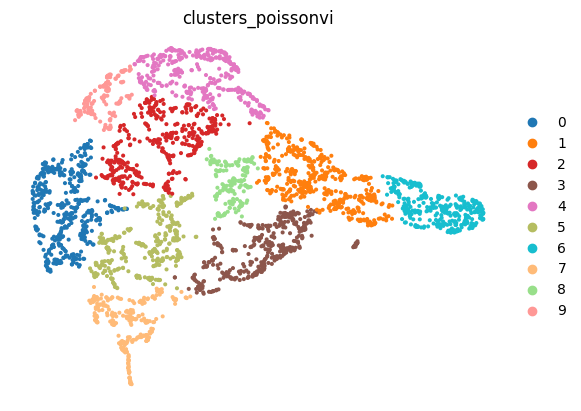

In [24]:
scvi.external.POISSONVI.setup_anndata(micro_atac, layer="fragments")
model = scvi.external.POISSONVI(micro_atac)
model.train()

POISSONVI_LATENT_KEY = "X_poissonvi"

latent = model.get_latent_representation()
micro_atac.obsm[POISSONVI_LATENT_KEY] = latent
print(latent.shape)

POISSONVI_CLUSTERS_KEY = "clusters_poissonvi"

# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(micro_atac, use_rep=POISSONVI_LATENT_KEY)
# compute the umap
sc.tl.umap(micro_atac, min_dist=0.2)
# cluster the space (we use a lower resolution to get fewer clusters than the default)
sc.tl.leiden(micro_atac, key_added=POISSONVI_CLUSTERS_KEY, resolution=0.2)
sc.pl.umap(micro_atac, color=POISSONVI_CLUSTERS_KEY,frameon=False)

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


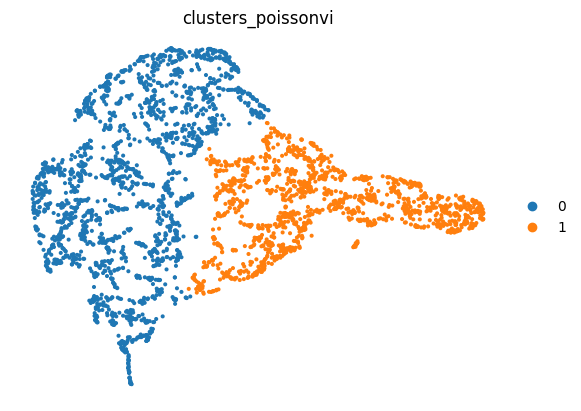

In [27]:
sc.tl.leiden(micro_atac, key_added=POISSONVI_CLUSTERS_KEY, resolution=0.02)
sc.pl.umap(micro_atac, color=POISSONVI_CLUSTERS_KEY,frameon=False)

In [28]:
micro_atac.obs.clusters_poissonvi.value_counts()

clusters_poissonvi
0    2108
1    1378
Name: count, dtype: int64

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_28016/3976732163.py:5: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train(early_stopping_patience=200,batch_size=203,plan_kwargs={"lr": 0.001})
/gpfs/home/ajoshi/.scvi_venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, 

Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:00<00:00,  8.41it/s, v_num=1, train_loss_step=354, train_loss_epoch=367]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [01:00<00:00,  8.32it/s, v_num=1, train_loss_step=354, train_loss_epoch=367]


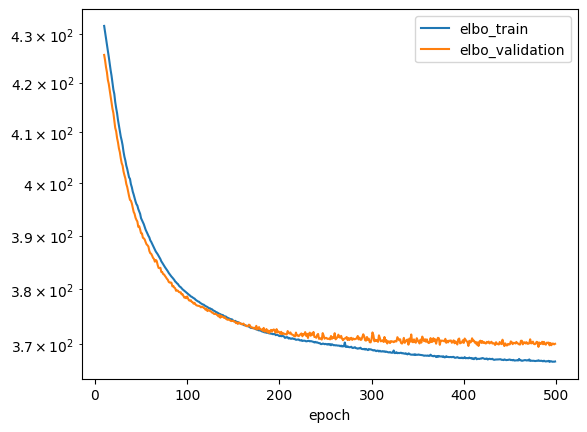

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


In [29]:
cells = list(np.where(micro_atac.obs.clusters_poissonvi=='0')[0])
micro_atac0 = micro_atac[cells].copy()
scvi.external.POISSONVI.setup_anndata(micro_atac0, layer="fragments")
model = scvi.external.POISSONVI(micro_atac0)  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
model.train(early_stopping_patience=200,batch_size=203,plan_kwargs={"lr": 0.001})
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
plt.show()
    
da_peaks0 = model.differential_accessibility(
    micro_atac0, idx1=micro_atac0.obs.condition=='hiv',idx2=micro_atac0.obs.condition=='controls',
    filter_outlier_cells=True,weights='uniform'
)
da_peaks0["log10_pscore"] = (-1)*np.log10(da_peaks0["proba_not_de"])

In [30]:
da_peaks0

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,emp_prob1,emp_prob2,emp_effect,is_de_fdr_0.05,log10_pscore
chr1-633500-634810,0.9818,0.0182,3.987965,0.001192,0.000712,0.0,0.05,0.779712,0.787392,1.763811,-4.464985,5.138806,0.159509,0.096144,0.063365,True,1.739929
chrM-1994-4168,0.9810,0.0190,3.944133,0.050782,0.029124,0.0,0.05,0.759660,0.764629,1.676097,-4.543279,5.469345,0.883436,0.899229,-0.015793,True,1.721246
chr17-22520704-22522275,0.9784,0.0216,3.813225,0.001038,0.000646,0.0,0.05,0.680849,0.699690,1.520393,-3.929931,4.622287,0.159509,0.086375,0.073134,True,1.665546
chrM-4681-5647,0.9780,0.0220,3.794467,0.015035,0.008997,0.0,0.05,0.722737,0.729933,1.607670,-4.255521,5.201658,0.595092,0.628792,-0.033700,True,1.657577
chrM-7501-8801,0.9774,0.0226,3.766946,0.016787,0.010051,0.0,0.05,0.726301,0.718246,1.619214,-4.355801,5.189701,0.558282,0.680720,-0.122438,True,1.645892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr3-13015359-13016803,0.5134,0.4866,0.053613,0.000421,0.000420,0.0,0.05,0.000574,0.003092,0.086163,-0.482856,0.302185,0.042945,0.052956,-0.010012,False,0.312828
chr6-28866093-28867236,0.5120,0.4880,0.048009,0.000588,0.000588,0.0,0.05,-0.002191,0.000444,0.080506,-0.401136,0.254457,0.061350,0.059640,0.001710,False,0.311580
chr3-72847974-72849046,0.5024,0.4976,0.009600,0.000511,0.000514,0.0,0.05,-0.009198,-0.002460,0.086465,-0.563137,0.294480,0.092025,0.046272,0.045752,False,0.303120
chr1-92079993-92080951,0.4608,0.5392,-0.157122,0.000422,0.000425,0.0,0.05,-0.009542,-0.008597,0.075212,-0.369660,0.336471,0.067485,0.049357,0.018127,False,0.268250


/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_28016/1356449472.py:5: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train(early_stopping_patience=200,batch_size=53,plan_kwargs={"lr": 0.1})
/gpfs/home/ajoshi/.scvi_venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, usi

Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [02:06<00:00,  3.98it/s, v_num=1, train_loss_step=580, train_loss_epoch=570]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████| 500/500 [02:06<00:00,  3.95it/s, v_num=1, train_loss_step=580, train_loss_epoch=570]


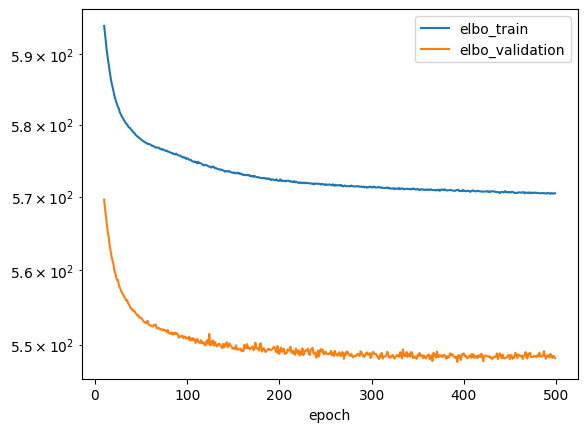

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,emp_prob1,emp_prob2,emp_effect,is_de_fdr_0.05,log10_pscore
chr1-628863-633090,0.9880,0.0120,4.410775,0.000284,0.000555,0.0,0.05,-1.580873,-1.495041,2.729856,-7.065587,6.740892,0.084854,0.053191,0.031663,True,1.920819
chr17-22520704-22522275,0.9840,0.0160,4.119037,0.000272,0.000529,0.0,0.05,-1.251381,-1.223860,2.000750,-5.592230,5.055565,0.068431,0.056738,0.011693,True,1.795880
chr18-49560782-49562244,0.9784,0.0216,3.813225,0.000462,0.000599,0.0,0.05,-0.848522,-0.732801,1.897085,-4.525663,4.447472,0.089416,0.031915,0.057501,True,1.665546
chrM-4681-5647,0.9782,0.0218,3.803804,0.003232,0.006048,0.0,0.05,-0.898208,-0.913863,1.334288,-4.210538,3.566548,0.544708,0.432624,0.112084,True,1.661544
chrM-1994-4168,0.9766,0.0234,3.731341,0.011359,0.021611,0.0,0.05,-0.929195,-0.955991,1.372683,-4.400295,3.645320,0.845803,0.741135,0.104668,True,1.630784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr15-51341209-51342303,0.4578,0.5422,-0.169203,0.000648,0.000638,0.0,0.05,0.021505,0.019712,0.066420,-0.210280,0.247991,0.161496,0.024823,0.136674,False,0.265840
chr16-28553664-28554660,0.4540,0.5460,-0.184522,0.000798,0.000792,0.0,0.05,0.011351,0.009089,0.070084,-0.262146,0.371576,0.181569,0.063830,0.117740,False,0.262807
chr3-10189293-10190419,0.4338,0.5662,-0.266364,0.000630,0.000626,0.0,0.05,0.008747,0.010061,0.061981,-0.272909,0.219580,0.167883,0.049645,0.118238,False,0.247030
chr2-85710803-85711923,0.4284,0.5716,-0.288382,0.000469,0.000472,0.0,0.05,-0.010473,-0.009877,0.062577,-0.228477,0.275576,0.096715,0.063830,0.032886,False,0.242908


In [31]:
cells = list(np.where(micro_atac.obs.clusters_poissonvi=='1')[0])
micro_atac1 = micro_atac[cells].copy()
scvi.external.POISSONVI.setup_anndata(micro_atac1, layer="fragments")
model = scvi.external.POISSONVI(micro_atac1)  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
model.train(early_stopping_patience=200,batch_size=53,plan_kwargs={"lr": 0.1})
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
plt.show()
    
da_peaks1 = model.differential_accessibility(
    micro_atac1, idx1=micro_atac1.obs.condition=='hiv',idx2=micro_atac1.obs.condition=='controls',
    filter_outlier_cells=True,weights='uniform'
)
da_peaks1["log10_pscore"] = (-1)*np.log10(da_peaks1["proba_not_de"])
da_peaks1

In [165]:
da_peaks1.iloc[np.where((da_peaks1['is_de_fdr_0.05']==True)&(da_peaks1['proba_not_de']<=0.05))[0],:]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,emp_prob1,emp_prob2,emp_effect,is_de_fdr_0.05,log10_pscore,chr,start,end
chr1-628863-633090,0.9880,0.0120,4.410775,0.000284,0.000555,0.0,0.05,-1.580873,-1.495041,2.729856,-7.065587,6.740892,0.084854,0.053191,0.031663,True,1.920819,chr1,628863,633090
chr17-22520704-22522275,0.9840,0.0160,4.119037,0.000272,0.000529,0.0,0.05,-1.251381,-1.223860,2.000750,-5.592230,5.055565,0.068431,0.056738,0.011693,True,1.795880,chr17,22520704,22522275
chr18-49560782-49562244,0.9784,0.0216,3.813225,0.000462,0.000599,0.0,0.05,-0.848522,-0.732801,1.897085,-4.525663,4.447472,0.089416,0.031915,0.057501,True,1.665546,chr18,49560782,49562244
chrM-4681-5647,0.9782,0.0218,3.803804,0.003232,0.006048,0.0,0.05,-0.898208,-0.913863,1.334288,-4.210538,3.566548,0.544708,0.432624,0.112084,True,1.661544,chrM,4681,5647
chrM-1994-4168,0.9766,0.0234,3.731341,0.011359,0.021611,0.0,0.05,-0.929195,-0.955991,1.372683,-4.400295,3.645320,0.845803,0.741135,0.104668,True,1.630784,chrM,1994,4168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr17-1999396-2000433,0.9506,0.0494,2.957143,0.000404,0.000517,0.0,0.05,-0.467198,-0.410940,0.943937,-2.220885,2.151298,0.104927,0.049645,0.055282,True,1.306273,chr17,1999396,2000433
chr3-14397097-14398185,0.9506,0.0494,2.957143,0.000404,0.000477,0.0,0.05,-0.314485,-0.287684,0.728894,-1.754845,1.736396,0.098540,0.031915,0.066625,True,1.306273,chr3,14397097,14398185
chr3-93470140-93471063,0.9504,0.0496,2.952892,0.002717,0.003616,0.0,0.05,-0.429090,-0.448772,0.614121,-1.892184,1.528727,0.464416,0.297872,0.166544,True,1.304518,chr3,93470140,93471063
chr19-20999407-21000375,0.9504,0.0496,2.952892,0.000314,0.000405,0.0,0.05,-0.493957,-0.405118,0.984462,-2.336066,2.189161,0.073905,0.031915,0.041990,True,1.304518,chr19,20999407,21000375


In [164]:
da_peaks0.iloc[np.where((da_peaks0['is_de_fdr_0.05']==True)&(da_peaks0['proba_not_de']<=0.05))[0],:]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,emp_prob1,emp_prob2,emp_effect,is_de_fdr_0.05,log10_pscore,chr,start,end
chr1-633500-634810,0.9818,0.0182,3.987965,0.001192,0.000712,0.0,0.05,0.779712,0.787392,1.763811,-4.464985,5.138806,0.159509,0.096144,0.063365,True,1.739929,chr1,633500,634810
chrM-1994-4168,0.9810,0.0190,3.944133,0.050782,0.029124,0.0,0.05,0.759660,0.764629,1.676097,-4.543279,5.469345,0.883436,0.899229,-0.015793,True,1.721246,chrM,1994,4168
chr17-22520704-22522275,0.9784,0.0216,3.813225,0.001038,0.000646,0.0,0.05,0.680849,0.699690,1.520393,-3.929931,4.622287,0.159509,0.086375,0.073134,True,1.665546,chr17,22520704,22522275
chrM-4681-5647,0.9780,0.0220,3.794467,0.015035,0.008997,0.0,0.05,0.722737,0.729933,1.607670,-4.255521,5.201658,0.595092,0.628792,-0.033700,True,1.657577,chrM,4681,5647
chrM-7501-8801,0.9774,0.0226,3.766946,0.016787,0.010051,0.0,0.05,0.726301,0.718246,1.619214,-4.355801,5.189701,0.558282,0.680720,-0.122438,True,1.645892,chrM,7501,8801
chrM-5939-7081,0.9746,0.0254,3.647278,0.017339,0.010395,0.0,0.05,0.716241,0.713369,1.586607,-4.214125,5.108109,0.668712,0.716710,-0.047998,True,1.595166,chrM,5939,7081
chr1-628863-633090,0.9728,0.0272,3.576961,0.000898,0.000599,0.0,0.05,0.565890,0.576211,1.257633,-3.388948,3.951401,0.177914,0.073522,0.104392,True,1.565431,chr1,628863,633090
chr20-29444913-29446092,0.9628,0.0372,3.253537,0.000450,0.000573,0.0,0.05,-0.396973,-0.382255,0.857441,-3.397202,2.255692,0.000000,0.068895,-0.068895,True,1.429457,chr20,29444913,29446092
chr2-238847579-238850049,0.9614,0.0386,3.215138,0.000258,0.000326,0.0,0.05,-0.371448,-0.378000,0.798320,-2.913501,2.100325,0.006135,0.032905,-0.026770,True,1.413413,chr2,238847579,238850049
chr2-240624677-240625805,0.9578,0.0422,3.122219,0.000321,0.000402,0.0,0.05,-0.349064,-0.351819,0.760369,-2.491332,1.984262,0.030675,0.039589,-0.008914,True,1.374688,chr2,240624677,240625805


In [40]:
############## Read in GENCODE for protein coding genes ################
from gtfparse import read_gtf
gencode=read_gtf("../../gencode.v44.annotation.gtf")
protein_coding_genes = list(gencode.gene_name[np.where((gencode.feature=='gene')
            &(gencode.gene_type=='protein_coding')
            )[0]])

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


In [41]:
pd.unique(micro_atac.obs.clusters_poissonvi)

['0', '1']
Categories (2, object): ['0', '1']

In [42]:
all_deg_glia.iloc[np.where(all_deg_glia['cell_type']=='Micro')[0],:]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,cell_type,selection_metric,sign_lfc,metric_gsea
gene_ids,,,,,,,,,,,,,,,,,,,,,
CD163,0.9918,0.0082,4.795386,2.749898e-04,3.352584e-06,0.0,0.25,6.195140,6.154420,3.062551,...,0.212035,0.001658,2.780784,0.012859,True,2.086186,Micro,29.512820,1,2.086186
ST14,0.9874,0.0126,4.361378,1.399495e-05,8.057685e-07,0.0,0.25,4.577775,4.516576,2.336659,...,0.021239,0.000829,0.142306,0.008142,True,1.899629,Micro,19.698494,1,1.899629
SLC22A1,0.9848,0.0152,4.171142,7.119654e-06,3.228133e-07,0.0,0.25,4.451330,4.483110,2.482512,...,0.009912,0.000276,0.061601,0.001915,True,1.818156,Micro,18.699689,1,1.818156
SOCS3,0.9846,0.0154,4.157867,1.536452e-05,2.000093e-05,0.0,0.25,4.496700,5.103317,4.440274,...,0.019115,0.018790,0.125085,0.180070,True,1.812479,Micro,21.218916,1,1.812479
ACSL1,0.9838,0.0162,4.106411,4.869384e-04,4.559288e-05,0.0,0.25,3.386738,3.470802,1.574281,...,0.417699,0.046698,4.800740,0.387609,True,1.790485,Micro,14.252540,1,1.790485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RASSF10,0.9710,0.0290,3.511030,2.914561e-07,3.048113e-06,0.0,0.25,-2.974279,-3.402520,3.695410,...,0.000354,0.004145,0.003814,0.034075,True,1.537602,Micro,11.946352,-1,-1.537602
OR2L5,0.9712,0.0288,3.518157,5.801867e-07,1.836105e-06,0.0,0.25,-2.927333,-3.036462,4.762988,...,0.001062,0.002487,0.007624,0.017166,True,1.540608,Micro,10.682748,-1,-1.540608
DPP4,0.9748,0.0252,3.655388,2.910912e-06,2.841889e-05,0.0,0.25,-4.018132,-4.079038,2.601806,...,0.003540,0.033711,0.014780,0.283802,True,1.598599,Micro,14.910466,-1,-1.598599


In [43]:
for genome_pos in da_peaks0.index:
    da_peaks0.loc[genome_pos,'chr']=genome_pos.split("-")[0]
    da_peaks0.loc[genome_pos,'start']=genome_pos.split("-")[1]
    da_peaks0.loc[genome_pos,'end']=genome_pos.split("-")[2]
da_peaks0['start']=da_peaks0['start'].astype('int')
da_peaks0['end']=da_peaks0['end'].astype('int')

/tmp/ipykernel_28016/457673829.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '633500' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  da_peaks0.loc[genome_pos,'start']=genome_pos.split("-")[1]
/tmp/ipykernel_28016/457673829.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '634810' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  da_peaks0.loc[genome_pos,'end']=genome_pos.split("-")[2]


In [44]:
for genome_pos in da_peaks1.index:
    da_peaks1.loc[genome_pos,'chr']=genome_pos.split("-")[0]
    da_peaks1.loc[genome_pos,'start']=genome_pos.split("-")[1]
    da_peaks1.loc[genome_pos,'end']=genome_pos.split("-")[2]
da_peaks1['start']=da_peaks1['start'].astype('int')
da_peaks1['end']=da_peaks1['end'].astype('int')

/tmp/ipykernel_28016/882698870.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '628863' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  da_peaks1.loc[genome_pos,'start']=genome_pos.split("-")[1]
/tmp/ipykernel_28016/882698870.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '633090' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  da_peaks1.loc[genome_pos,'end']=genome_pos.split("-")[2]


In [182]:
num_peaks_for_genes=pd.DataFrame(columns=pd.unique(micro_atac.obs.clusters_poissonvi))
all_deg_frame=all_deg_glia.iloc[np.where((all_deg_glia['cell_type']=='Micro'))[0],:]
for gene in pd.unique(all_deg_frame.iloc[np.where(all_deg_frame['is_de_fdr_0.05']==True)[0],:].index):
    chr,start,end=gencode.iloc[np.where((gencode.feature=='gene')&(gencode.gene_name==gene))[0],[0,3,4]].values[0]
    gene_peaks0 = da_peaks0.iloc[np.where((da_peaks0['is_de_fdr_0.05']==True)&(da_peaks0['proba_not_de']<=0.05)
                    &(da_peaks0.index.str.contains(chr))
                    &((da_peaks0['start']>start-5000)&(da_peaks0['end']<end+5000))
                    )[0],:]
    gene_peaks1 = da_peaks1.iloc[np.where((da_peaks1['is_de_fdr_0.05']==True)&(da_peaks1['proba_not_de']<=0.05)
                    &(da_peaks1.index.str.contains(chr))
                    &((da_peaks1['start']>start-5000)&(da_peaks1['end']<end+5000))
                    )[0],:]

    num_peaks_for_genes.loc[gene,'0']=len(gene_peaks0)
    num_peaks_for_genes.loc[gene,'1']=len(gene_peaks1)

In [183]:
num_peaks_for_genes

,0,1
CD163,0,0
ST14,0,0
SLC22A1,0,0
SOCS3,0,0
ACSL1,0,0
...,...,...
RASSF10,0,0
OR2L5,0,0
DPP4,0,0
CTF1,0,0


In [184]:
num_peaks_for_genes[(num_peaks_for_genes.T != 0).any()]

,0,1
CXCR4,0,2
ADAM8,0,1
SLC47A1,0,1
SERPINE1,1,0
GPR35,1,0
RGS1,0,1
ALK,1,2
BRINP2,0,1
LIPG,0,1
CDH13,0,2


In [192]:
gene_peaks1

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,emp_prob1,emp_prob2,emp_effect,is_de_fdr_0.05,log10_pscore,chr,start,end


In [193]:
gencode.iloc[np.where((gencode.feature=='gene')&(gencode.gene_name=='DYNLT2B'))[0],[0,3,4]].values[0]

array(['chr3', 196291219, 196318299], dtype=object)

In [185]:
num_peaks_for_genes.to_csv('/gpfs/home/ajoshi/results/SCORCH_HIV/num_peaks_for_genes_microglia.tsv',sep='\t')

In [186]:
num_peaks_for_genes=pd.read_csv('/gpfs/home/ajoshi/results/SCORCH_HIV/num_peaks_for_genes_microglia.tsv',sep='\t',index_col=0)
num_peaks_for_genes

,0,1
CD163,0,0
ST14,0,0
SLC22A1,0,0
SOCS3,0,0
ACSL1,0,0
...,...,...
RASSF10,0,0
OR2L5,0,0
DPP4,0,0
CTF1,0,0


In [194]:
all_deg_glia.iloc[np.where((all_deg_glia.cell_type=='Micro')
                           &(all_deg_glia.index.isin(list(num_peaks_for_genes.iloc[np.where(num_peaks_for_genes['0']>=1)[0],:].index)))
                          )[0],:].metric_gsea

gene_ids
SERPINE1    1.251812
GPR35       1.223299
ALK        -1.221849
Name: metric_gsea, dtype: float64

In [210]:
input_gsea = pd.DataFrame(columns=['metric_gsea'])
input_gsea = all_deg_glia.iloc[np.where((all_deg_glia.cell_type=='Micro')
                           &(all_deg_glia.index.isin(list(num_peaks_for_genes.iloc[np.where(num_peaks_for_genes['0']>=1)[0],:].index)))
                          )[0],:].metric_gsea
input_gsea = input_gsea.sort_values(ascending=False)
gsea_all_paths0 = pd.DataFrame()
        
## Exception handling for when the gmt gene set is irrelevant for the differentially expressed genes
gsea_result = gseapy.prerank(rnk=input_gsea, gene_sets=gene_sets_to_test, organism='human')
    
filtered_sets = gsea_result.res2d
if len(filtered_sets)>0:
    gsea_all_paths0 = pd.concat([gsea_all_paths0,filtered_sets]).reset_index(drop=True)
    gsea_all_paths0=gsea_all_paths0.drop_duplicates()
list(gsea_all_paths0.iloc[np.where(gsea_all_paths0['NOM p-val']<=0.05)[0],:].Term)

2025-06-20 13:50:13,676 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

2025-06-20 13:50:13,678 [ERROR] The first entry of your gene_sets (gmt) look like this : { GO_Biological_Process_2023__'De Novo' AMP Biosynthetic Process (GO:0044208): [PAICS, ATIC, PFAS, ADSS1, GART, ADSS2]}
2025-06-20 13:50:13,679 [ERROR] The first 5 genes look like this : [ SERPINE1, GPR35, ALK ]


LookupError: No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.


In [211]:
input_gsea = pd.DataFrame(columns=['metric_gsea'])
input_gsea = all_deg_glia.iloc[np.where((all_deg_glia.cell_type=='Micro')
                           &(all_deg_glia.index.isin(list(num_peaks_for_genes.iloc[np.where(num_peaks_for_genes['1']>=1)[0],:].index)))
                          )[0],:].metric_gsea
input_gsea = input_gsea.sort_values(ascending=False)
gsea_all_paths1 = pd.DataFrame()
        
## Exception handling for when the gmt gene set is irrelevant for the differentially expressed genes
gsea_result = gseapy.prerank(rnk=input_gsea, gene_sets=gene_sets_to_test, organism='human')
    
filtered_sets = gsea_result.res2d
if len(filtered_sets)>0:
    gsea_all_paths1 = pd.concat([gsea_all_paths1,filtered_sets]).reset_index(drop=True)
    gsea_all_paths1=gsea_all_paths1.drop_duplicates()
list(gsea_all_paths1.iloc[np.where(gsea_all_paths1['NOM p-val']<=0.05)[0],:].Term)

2025-06-20 13:50:23,348 [WARNING] Duplicated values found in preranked stats: 11.11% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-06-20 13:50:23,497 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.

2025-06-20 13:50:23,499 [ERROR] The first entry of your gene_sets (gmt) look like this : { GO_Biological_Process_2023__'De Novo' AMP Biosynthetic Process (GO:0044208): [PAICS, ATIC, PFAS, ADSS1, GART, ADSS2]}
2025-06-20 13:50:23,500 [ERROR] The first 5 genes look like this : [ CXCR4, ADAM8, SLC47A1, RGS1, ALK ]


LookupError: No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.


In [213]:
micro_adata.write_h5ad('/gpfs/home/ajoshi/HIV_data/single_cell_scorch/microglia_rna_adata.h5ad',compression='gzip')

... storing 'condition' as categorical


In [214]:
micro_atac.write_h5ad('/gpfs/home/ajoshi/HIV_data/single_cell_scorch/microglia_atac_adata.h5ad',compression='gzip')